In [11]:
!pip install librosa numpy matplotlib fastdtw scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=2f3765abb7a2284bfdc692327092f52c8d8dedce70e6f9287c4dce085cbe7a70
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw



Loading audio files...
Loaded successfully.

DTW Distance: 28.0823
Alignment Path Length: 282


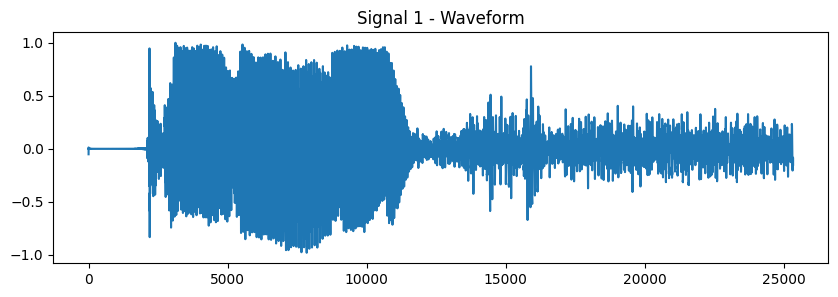

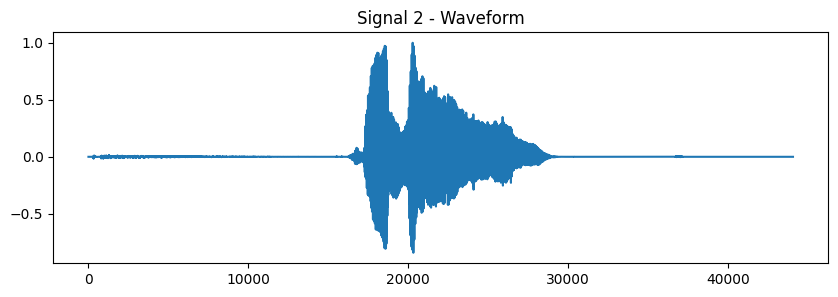

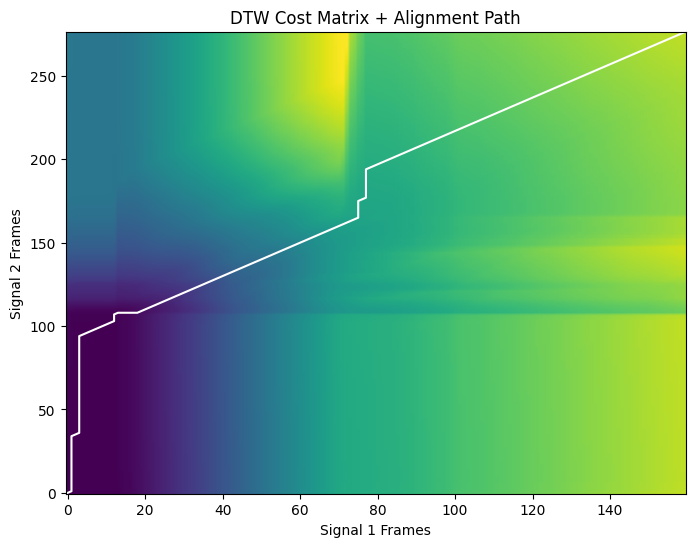

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

# !!! UPDATE THESE PATHS !!!
audio_path_1 = r"/content/my voice.wav"   # <-- Your voice saying "hello"
audio_path_2 = r"/content/frnd voice.wav"   # <-- Friend's voice saying "hello"
sr_target = 16000  # resample rate

# Functions
def load_wav(filepath, target_sr=16000):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Audio file not found: {filepath}")

    sr, data = wavfile.read(filepath)

    # Convert to float range [-1,1]
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32768.0
    elif data.dtype == np.int32:
        data = data.astype(np.float32) / 2147483648.0
    elif data.dtype == np.uint8:
        data = (data.astype(np.float32) - 128.0) / 128.0
    else:
        data = data.astype(np.float32)

    if data.ndim > 1:  # Stereo → Mono
        data = np.mean(data, axis=1)

    # Resample if necessary
    if sr != target_sr:
        num = int(round(len(data) * float(target_sr) / sr))
        data = signal.resample(data, num)
        sr = target_sr

    return sr, data


def normalize_audio(x):
    x = x - np.mean(x)
    max_val = np.max(np.abs(x))
    return x / max_val if max_val > 0 else x


def frames_from_waveform(x, sr, n_fft=512, hop_length=160):
    f, t, Zxx = signal.stft(x, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
    return np.log1p(np.abs(Zxx)).T


def compute_cost_matrix(X, Y):
    X2 = np.sum(X ** 2, axis=1, keepdims=True)
    Y2 = np.sum(Y ** 2, axis=1, keepdims=True)
    D2 = X2 + Y2.T - 2 * (X @ Y.T)
    return np.sqrt(np.maximum(D2, 0.0))


def dtw_distance_and_path(D):
    n, m = D.shape
    C = np.full((n+1, m+1), np.inf)
    C[0,0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            C[i,j] = D[i-1,j-1] + min(C[i-1,j], C[i,j-1], C[i-1,j-1])

    # Backtrace DTW path
    path = []
    i, j = n, m
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        step = min((C[i-1, j], 1, 0),
                   (C[i, j-1], 0, 1),
                   (C[i-1, j-1], 1, 1))
        i -= step[1]
        j -= step[2]

    return C[1:,1:], list(reversed(path)), C[-1,-1]


# Load Audio Files
print("\nLoading audio files...")
sr1, signal1 = load_wav(audio_path_1, sr_target)
sr2, signal2 = load_wav(audio_path_2, sr_target)
print("Loaded successfully.\n")

# Normalize Signals
signal1 = normalize_audio(signal1)
signal2 = normalize_audio(signal2)

# Extract Features (Spectrogram)
frames1 = frames_from_waveform(signal1, sr1)
frames2 = frames_from_waveform(signal2, sr2)

min_bins = min(frames1.shape[1], frames2.shape[1])
frames1 = frames1[:, :min_bins]
frames2 = frames2[:, :min_bins]

# DTW Calculation
D = compute_cost_matrix(frames1, frames2)
C, path, distance = dtw_distance_and_path(D)

print(f"DTW Distance: {distance:.4f}")
print(f"Alignment Path Length: {len(path)}")

# Plot Results
plt.figure(figsize=(10,3))
plt.title("Signal 1 - Waveform")
plt.plot(signal1)

plt.figure(figsize=(10,3))
plt.title("Signal 2 - Waveform")
plt.plot(signal2)

plt.figure(figsize=(8,6))
plt.imshow(C.T, origin="lower", aspect="auto")
plt.plot([p[0] for p in path], [p[1] for p in path], 'w')
plt.title("DTW Cost Matrix + Alignment Path")
plt.xlabel("Signal 1 Frames")
plt.ylabel("Signal 2 Frames")
plt.show()


RESULT INTERPRETATION:
✔ DTW Total Distance = 28.0823
- A lower distance indicates the recordings are highly similar.
- The alignment path shows how DTW stretches or compresses time to match both signals,
  even if one person spoke faster or slower while saying 'hello'.

#Interpretation of Graph 1 — Waveform Comparison

This graph shows the time-domain waveform representations of Signal 1 (my voice) and Signal 2 ( friend's voice).

Signal 1 waveform is longer and shows higher amplitude variation. This suggests the speaker pronounced "hello" with more emphasis, loudness, or duration.

Signal 2 waveform is shorter and smoother with less amplitude variation, indicating the pronunciation was faster and possibly softer.

Both signals contain a clear voiced section that corresponds to the word "hello," but the timing, duration, and amplitude differ.

The visual difference confirms that while the two recordings represent the same spoken word, natural variations in speech style, loudness, and pacing cause the waveform shapes to appear different.

#Interpretation of Graph 2 — DTW Cost Matrix with Alignment Path

This graph visualizes the Dynamic Time Warping (DTW) cost matrix and the alignment path:

The colored background represents the matching cost between frames of Signal 1 and Signal 2:

Darker colors indicate a better match (lower cost).

Lighter colors represent higher mismatch.

The white line is the computed optimal alignment path, showing how DTW stretches or compresses the time axis to match the two audio signals.

Key observations:

The alignment path is not a perfect diagonal line, which means the two signals do not align perfectly in real time.

The path bends and stretches where one speaker said parts of the word slower or faster.

The mostly smooth but slightly curved path shows that the signals share similar structure, meaning both contain the same phonetic pattern, but take different amounts of time to complete.

This graph demonstrates how DTW finds the best temporal alignment, even when speech pacing is different.